## Hate Speech and Offensive Language Detection Using Natural Language Processing

### Babirye Daphne  (R00224283)<br>
### Project 2<br>
### Applied Machine Learning<br>
### Msc Data Science and Analytics <br>


##### Section 1: Importing Data

In [2]:
# Import required libraries 

import pandas as pd
import numpy as np

In [79]:
# import the data

data = pd.read_csv('labeled_data.csv')

In [80]:
# check the imported data
data.head() # show first 5 lines 

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [81]:
# check the dimesnsions of the data

nRow, nCol = data.shape
print('There are {} rows and {} columns'.format(nRow, nCol))

# Source: https://www.kaggle.com/code/giovanimachado/hate-speech-bert-cnn-and-bert-mlp-in-tensorflow

There are 24783 rows and 7 columns


In [82]:
# slicing the dataframe to have only the text and class

df = data[['class','tweet']]
df.head()




,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


#### Section 2: Data Cleaning and EDA

In [83]:
# Check for missing values 

df.isnull().sum()

#there are no missing values in the dataset

class    0
tweet    0
dtype: int64

In [84]:
#Add a category column for visualising the categories in the summary statistics
df = df.copy()
df.loc[:, 'category'] = df['class'].map({0: 'hate_speech', 1: 'offensive_language', 2: 'neither'})
df.head()

,class,tweet,category
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language


In [86]:
# check the number of observations in each class 

# Grouping data by label
category_count = df.groupby('category').count()

# specify the name of the file
file_name = 'category_count.xlsx'
  
# save to excel
category_count.to_excel(file_name)

category_count

# the data is imbalanced across categories

,class,tweet
category,,
hate_speech,1430,1430
neither,4163,4163
offensive_language,19190,19190


In [87]:
#Determine the percentage of observations in each category

# Determine the count of each category
counts = df['category'].value_counts()

# Determine the total number of observations
total = counts.sum()

# Calculate the percentage of observations in each category
percentages = counts / total * 100

# specify the name of the file
file_name = 'percentages.xlsx'
  
# save to excel
percentages.to_excel(file_name)

# Print the results
for category, count, percentage in zip(counts.index, counts, percentages):
    print('{}:\n    Total: {}\n    Count: {} ({:.2f}% of total)\n'.format(category, total, count, percentage))

# the categories are greatly imbalanced 
    


offensive_language:
    Total: 24783
    Count: 19190 (77.43% of total)

neither:
    Total: 24783
    Count: 4163 (16.80% of total)

hate_speech:
    Total: 24783
    Count: 1430 (5.77% of total)



In [98]:
#Slice the data to remain with only the class and tweets

df_new = df. iloc[:, [0,1]]
df_new


,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


In [104]:
#Rename class column name to target

df_new.rename(columns = {'class':'target'}, inplace = True)
df_new.head()

,target,tweet
0,2,rt mayasolovely woman shouldnt complain cleani...
1,1,rt mleew boy dat coldtyga dwn bad cuffin dat h...
2,1,rt urkindofbrand dawg rt sbabylife ever fuck b...
3,1,rt cganderson vivabased look like tranny
4,1,rt shenikaroberts shit hear might true might f...


<b> Text Cleaning<b/> <br>
    
This will include removing punctuation, stop words, unnecessary words, white spaces, and symbols that are not required.

In [99]:
#Remove Duplicates

df_new = df_new.drop_duplicates('tweet')

df.shape
# no duplicates

(24783, 3)

In [89]:
#Import text cleaning libraries and sub-libraries 

import nltk
nltk.download('punkt') 
from nltk.corpus import stopwords # to identify and remove stop words
from nltk.stem import WordNetLemmatizer # to perform text lemmatization
from nltk import word_tokenize # for word tokenization
import string



import re # to implement the created function

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\babir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Create function for text cleaning 

In [100]:
# A function to clean the text 

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra white spaces and newline characters
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenize text into words
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into text
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

df_new['tweet'] = df_new['tweet'].apply(lambda x: clean_text(x))


#Source of idea: https://www.section.io/engineering-education/using-imbalanced-learn-to-handle-imbalanced-text-data/       

In [105]:
#Check the cleaned data to ensure that it has ben cleaned

df_new.head()


,target,tweet
0,2,rt mayasolovely woman shouldnt complain cleani...
1,1,rt mleew boy dat coldtyga dwn bad cuffin dat h...
2,1,rt urkindofbrand dawg rt sbabylife ever fuck b...
3,1,rt cganderson vivabased look like tranny
4,1,rt shenikaroberts shit hear might true might f...


<b> Visualise Key Words under all Categories of the data using Word Clouds

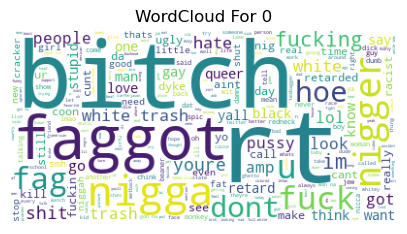

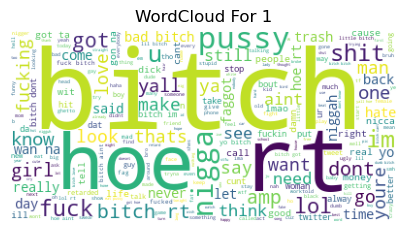

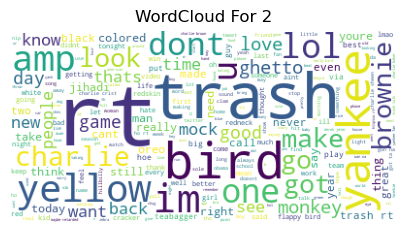

In [143]:
# Creat word clouds for each category using train data

def wordcloud_plot(df_new: pd.DataFrame, target: int) -> None:
    # Extract the tweet text for the specified target
    words = " ".join(df_new[df_new["target"] == target]["tweet"].values)

    # Set the figure size for the word cloud plot
    plt.rcParams['figure.figsize'] = 5, 10

    # Generate the word cloud
    wordcloud = WordCloud(stopwords=STOPWORDS, 
                          background_color="white",
                          max_words=500).generate(words)

    # Set the title for the word cloud plot
    plt.title("WordCloud For {}".format(target))

    # Display the word cloud plot
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

# Define the mapping dictionary
mapping = {0: 'hate_speech', 1: 'offensive_language', 2: 'neither'}

# Loop over targets and categories
for target, category in mapping.items():
    # Generate word cloud for each target
    wordcloud_plot(df_new, target)



<b>Split data into Train and test

In [139]:
#Split data into train and test

# Import the necessary library
from sklearn.model_selection import train_test_split

# Splitting the data between train and test sets

# Split the tweet values of the DataFrame as X (input) and the target values as y (output)
X_train, X_test, y_train, y_test = train_test_split(
    df_new.tweet.values,
    df_new.target.values,
    test_size=0.20,  # Specify the proportion of the data to allocate for the test set
    random_state=283,  # Set a random state for reproducibility
    stratify=df_new.target.values  # Preserve the distribution of target values in the train-test split
)

print(X_train)

print(X_test)


['rt damestrcash jaetips know thats trash'
 'yall bitch muslim yall hair fucked ctfu stop young'
 'rt ciavdia wow well arent fucking cunt' ...
 'puckluckbitch relaxvibes like got time wasting bitch broke'
 'ronnie radkes fucking fag fronz owns as' 'ratchetandsassy hoe']
['x yellow tower gilbert claes httptcoqcifgfg'
 'rt nogoodnigger stop gassing regular as bitch' 'jayswaggkillah fag' ...
 'triple fudge brownie chunk ice cream lifechanging'
 'rt julioisurdaddy need man pussy boy' 'ronsonsolaqa love pussy lmaooo']


Count the observations per category in train and test data

In [142]:
# Create a DataFrame to count observations per category in the target variable
train_counts = pd.Series(y_train).value_counts()
test_counts = pd.Series(y_test).value_counts()

# Print the observations per category in the target variable for train and test sets
print("Train Set:")
print(train_counts)
print("\nTest Set:")
print(test_counts)

Train Set:
1    15352
2     3330
0     1144
dtype: int64

Test Set:
1    3838
2     833
0     286
dtype: int64


<B> Word encoding with the TFIDF Vectorizer

In [145]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the text data
vectorizer.fit(X_train)

# Transform the tweets data into TF-IDF encoded vectors
X_train_encoded = vectorizer.transform(X_train)
X_test_encoded = vectorizer.transform(X_test)

# Print the shape of the encoded vectors
print("Shape of X_train_encoded:", X_train_encoded.shape)
print("Shape of X_test_encoded:", X_test_encoded.shape)


# Print the  encoded vectors
print(X_train_encoded.toarray())
print(X_test_encoded.toarray())

Shape of X_train_encoded: (19826, 29504)
Shape of X_test_encoded: (4957, 29504)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Imbalanced Data 

##### Implement Classification Models

In [ ]:
# Import Libraries 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm


<b> Naive Bayes Model <b/><br> 
    
    (discussed in section 4.1.Model Exploration)

In [178]:

#Function for the naive Bayes Classifier

def naive_bayes_classifier(X_train, y_train):
    # Create a Naive Bayes classifier
    nb_classifier = MultinomialNB()

    # Fit the classifier with the training data
    nb_classifier.fit(X_train, y_train)

    # Perform cross-fold validation with predictions
    y_pred = cross_val_predict(nb_classifier, X_train, y_train, cv=10)

    # Generate confusion matrix
    cm = confusion_matrix(y_train, y_pred)

    # Plot confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_classifier.classes_)
    cm_display.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # Print accuracy, recall, precision, and F1 scores
    classification_rep = classification_report(y_train, y_pred, zero_division=0)
    print("Classification Report:\n", classification_rep)
    
#Source: https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

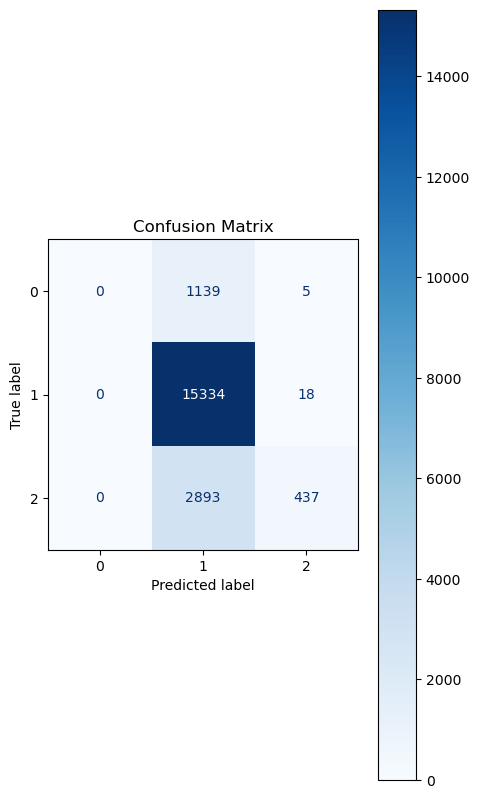

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1144
           1       0.79      1.00      0.88     15352
           2       0.95      0.13      0.23      3330

    accuracy                           0.80     19826
   macro avg       0.58      0.38      0.37     19826
weighted avg       0.77      0.80      0.72     19826



In [179]:
# Implement the NB classifier model

naive_bayes_classifier(X_train_encoded, y_train)

<b> Support Vector Machines <br>
    
 (discussed in section 4.1.Model Exploration)

In [182]:
# Function for SVM classifier

def svm_classifier(X_train, y_train):
    # Create an SVM classifier
    svm_classifier = svm.SVC(decision_function_shape='ovo')

    # Fit the classifier on the training data
    svm_classifier.fit(X_train, y_train)

    # Perform cross-validation with the SVM classifier
    y_pred = cross_val_predict(svm_classifier, X_train, y_train, cv=10)

    # Generate confusion matrix
    cm = confusion_matrix(y_train, y_pred)

    # Plot confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_classifier.classes_)
    cm_display.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # Print accuracy, recall, precision, and F1 scores
    classification_rep = classification_report(y_train, y_pred, zero_division=0)
    print("Classification Report:\n", classification_rep)

##Source: https://scikit-learn.org/stable/modules/svm.html

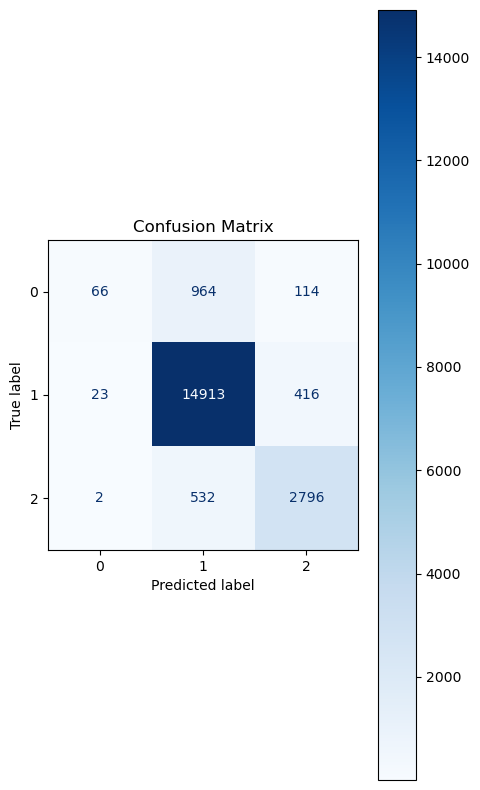

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.06      0.11      1144
           1       0.91      0.97      0.94     15352
           2       0.84      0.84      0.84      3330

    accuracy                           0.90     19826
   macro avg       0.82      0.62      0.63     19826
weighted avg       0.89      0.90      0.87     19826



In [183]:
#Implement the SVM Model on imbalanced DAta 
svm_classifier(X_train_encoded, y_train)


<b> Random Forest Classifier <br>
    
  (discussed in section 4.1.Model Exploration)

In [184]:
from sklearn.ensemble import RandomForestClassifier

#Function for the random forest model
def random_forest_classifier(X_train, y_train):
    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier(random_state=283)

    # Fit the classifier on the training data
    rf_classifier.fit(X_train, y_train)

    # Perform cross-fold validation with predictions
    y_pred = cross_val_predict(rf_classifier, X_train, y_train, cv=10)

    # Generate confusion matrix
    cm = confusion_matrix(y_train, y_pred)

    # Plot confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
    cm_display.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # Print accuracy, recall, precision, and F1 scores
    classification_rep = classification_report(y_train, y_pred, zero_division=0)
    print("Classification Report:\n", classification_rep)

#Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

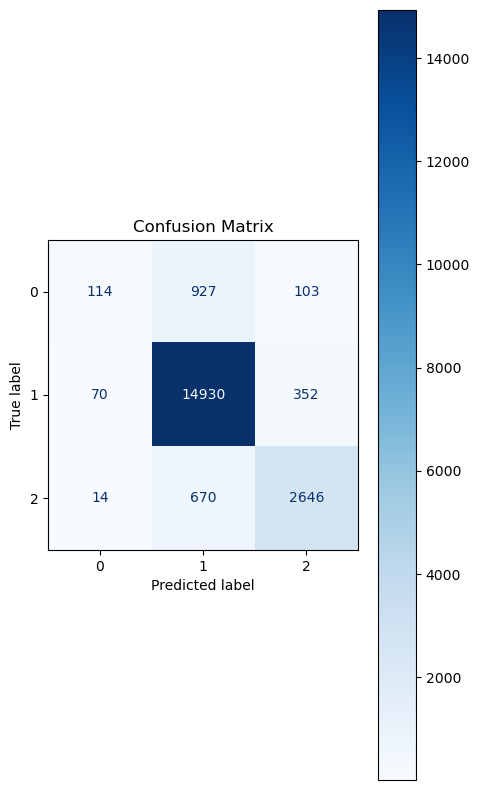

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.10      0.17      1144
           1       0.90      0.97      0.94     15352
           2       0.85      0.79      0.82      3330

    accuracy                           0.89     19826
   macro avg       0.78      0.62      0.64     19826
weighted avg       0.88      0.89      0.87     19826



In [185]:
# Implementing the random forest Model
random_forest_classifier(X_train_encoded, y_train)


<b>Tuning the random Forest model (best model) <br>
    
 (discussed in section 3.2.	Methods )

In [197]:
# Perform grid search to get the best parameters for the random forest model 

from sklearn.model_selection import GridSearchCV

def random_forest_classifier(X_train, y_train):
    # Define the parameter grid for grid search
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 5],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'random_state' : [283]
    }

    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier(random_state=283)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(rf_classifier, param_grid, cv=2, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score from grid search
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Fit the classifier on the training data with the best parameters
    rf_classifier.set_params(**best_params)
    rf_classifier.fit(X_train, y_train)

    # Perform cross-fold validation with predictions
    y_pred = cross_val_predict(rf_classifier, X_train, y_train, cv=10)

    # Generate confusion matrix
    cm = confusion_matrix(y_train, y_pred)

    # Plot confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
    cm_display.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # Print accuracy, recall, precision, and F1 scores
    classification_rep = classification_report(y_train, y_pred, zero_division=0)
    print("Classification Report:\n", classification_rep)

    # Return the best parameters and best score
    return best_params, best_score




#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

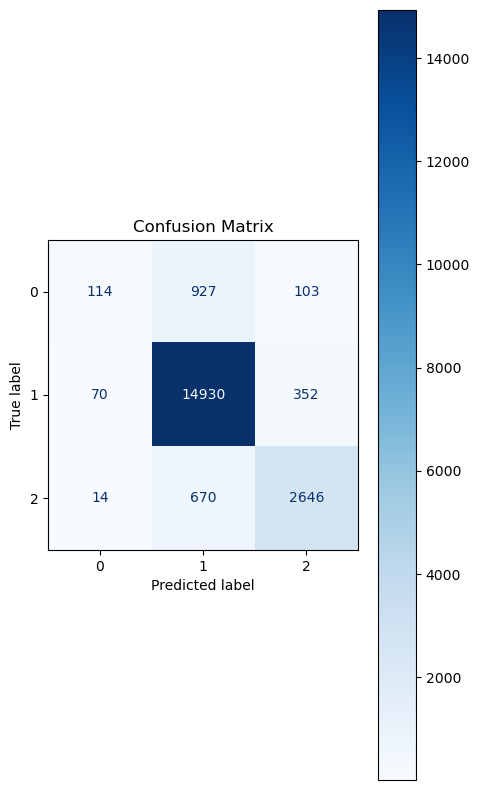

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.10      0.17      1144
           1       0.90      0.97      0.94     15352
           2       0.85      0.79      0.82      3330

    accuracy                           0.89     19826
   macro avg       0.78      0.62      0.64     19826
weighted avg       0.88      0.89      0.87     19826

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 283}
Best Score: 0.8858569555129627


In [198]:
# implement the function with the resampled training data and labels
best_params, best_score = random_forest_classifier(X_train_encoded, y_train)

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)


In [ ]:
# Tunung using grid search did not improve the model including the predictions in the confusion matrix so, we used the original model as our best model

<b> Evaluation of the best Model on the test Data  (Random Forest Model) <br>
    
  The RF model had best overall recall and F1. score across the three classes
  (Discussed in section 4.2.2.Evaluation on Test data )

In [186]:
#Function to evaluate the best model on test data 
def evaluate_model_on_test_data(model, X_test, y_test):
    # Evaluate on test data
    y_pred_test = model.predict(X_test)

    classification_rep_test = classification_report(y_test, y_pred_test, zero_division=0)
    print("Classification Report:\n", classification_rep_test)

    cm_test = confusion_matrix(y_test, y_pred_test)
    # Plot confusion matrix
    cm_test_display = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.classes_)
    cm_test_display.plot(cmap='Blues')
    plt.title("Confusion Matrix (Test Data)")
    plt.show()

    # Print the confusion matrix for test data
    print("Confusion Matrix (Test Data):\n", cm_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.14      0.22       286
           1       0.90      0.98      0.94      3838
           2       0.88      0.76      0.82       833

    accuracy                           0.89      4957
   macro avg       0.79      0.63      0.66      4957
weighted avg       0.88      0.89      0.87      4957



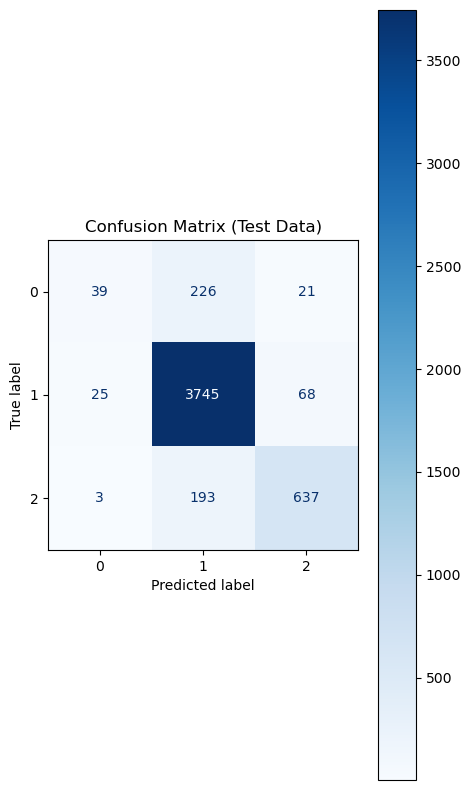

Confusion Matrix (Test Data):
 [[  39  226   21]
 [  25 3745   68]
 [   3  193  637]]


In [187]:
#Implement the model

evaluate_model_on_test_data(rf_classifier, X_test_encoded, y_test)

## 2.0 Balanced Dataset

###  2.1 Balance the dataset using SMOTE

(Discussed in section 3.1.4.Smote for balancing the dataset)

In [171]:
#install imbalaced learn
!pip install imbalanced-learn

     -------------------------------------- 226.0/226.0 kB 1.3 MB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 1.4 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [174]:
# import sampling libraries 
from imblearn.over_sampling import SMOTE

In [176]:
# create the SMOTE object:
smote = SMOTE(random_state=283)

#Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

#Check the class distribution before and after applying SMOTE:

# Before SMOTE
print("Before SMOTE:")
unique_classes, class_counts = np.unique(y_train, return_counts=True)
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples")

# After SMOTE
print("After SMOTE:")
unique_classes_resampled, class_counts_resampled = np.unique(y_train_resampled, return_counts=True)
for class_label, count in zip(unique_classes_resampled, class_counts_resampled):
    print(f"Class {class_label}: {count} samples")
    
    
#Source: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
        

Before SMOTE:
Class 0: 1144 samples
Class 1: 15352 samples
Class 2: 3330 samples
After SMOTE:
Class 0: 15352 samples
Class 1: 15352 samples
Class 2: 15352 samples


### 2.2. Model Fitting Using Balanced Data

#### 2.2.1 Naive Bayes Classifer  - Balanced Data
(discussed in section 4.1.Model Exploration)

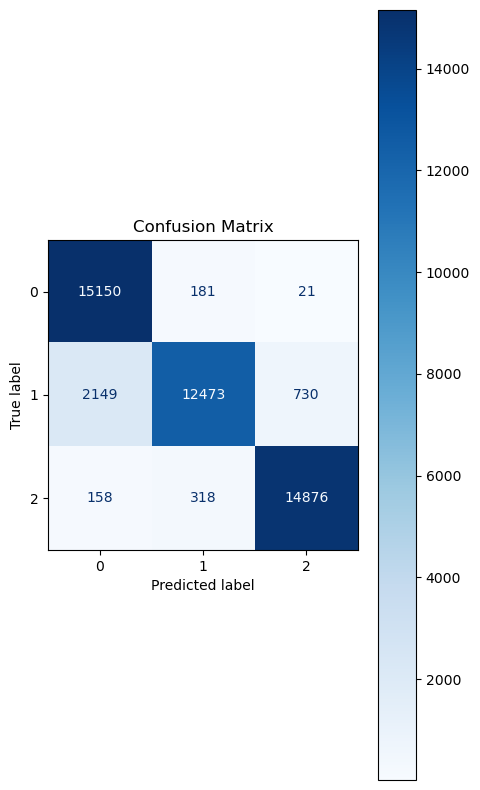

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.92     15352
           1       0.96      0.81      0.88     15352
           2       0.95      0.97      0.96     15352

    accuracy                           0.92     46056
   macro avg       0.93      0.92      0.92     46056
weighted avg       0.93      0.92      0.92     46056



In [181]:
naive_bayes_classifier(X_train_resampled, y_train_resampled)


#Source: https://scikit-learn.org/stable/supervised_learning.html

##### Support Vector Machines on Balanced Data
 (discussed in section 4.1.Model Exploration)

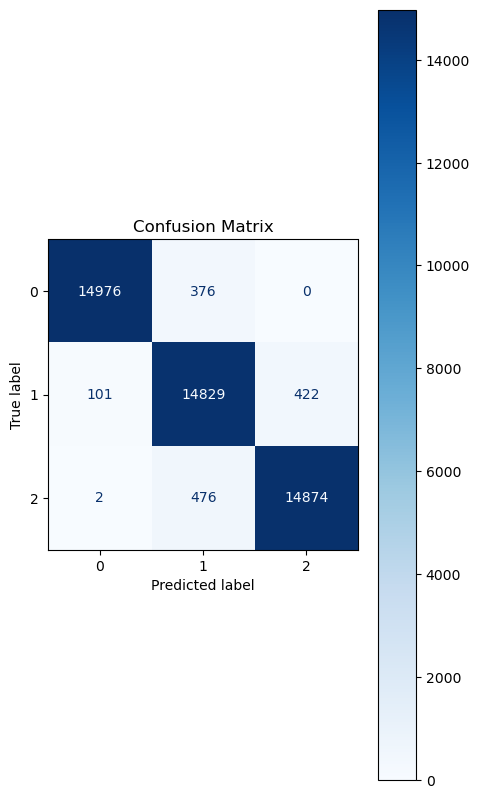

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     15352
           1       0.95      0.97      0.96     15352
           2       0.97      0.97      0.97     15352

    accuracy                           0.97     46056
   macro avg       0.97      0.97      0.97     46056
weighted avg       0.97      0.97      0.97     46056



In [189]:
svm_classifier(X_train_resampled, y_train_resampled)

##### Random Forest Model on Balanced Data
 (discussed in section 4.1.Model Exploration)

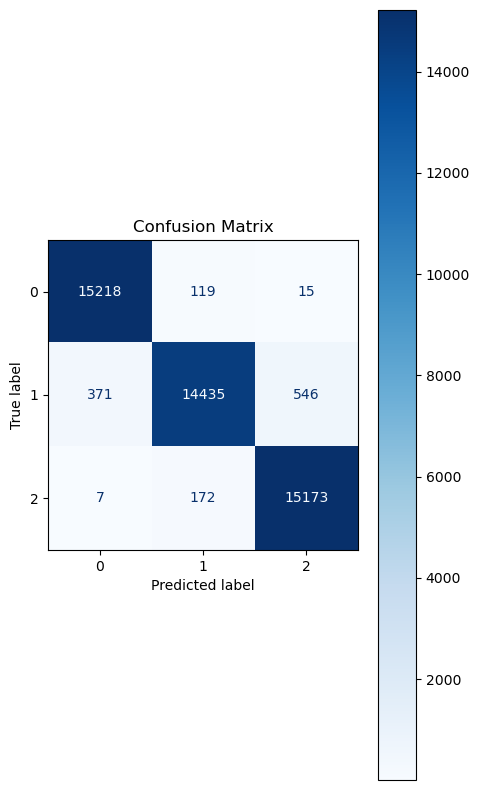

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     15352
           1       0.98      0.94      0.96     15352
           2       0.96      0.99      0.98     15352

    accuracy                           0.97     46056
   macro avg       0.97      0.97      0.97     46056
weighted avg       0.97      0.97      0.97     46056



In [190]:
random_forest_classifier(X_train_resampled, y_train_resampled)

<b> Tunning the best model - Random Forest Model
 
     (discussed in section 3.2.	Methods )
 

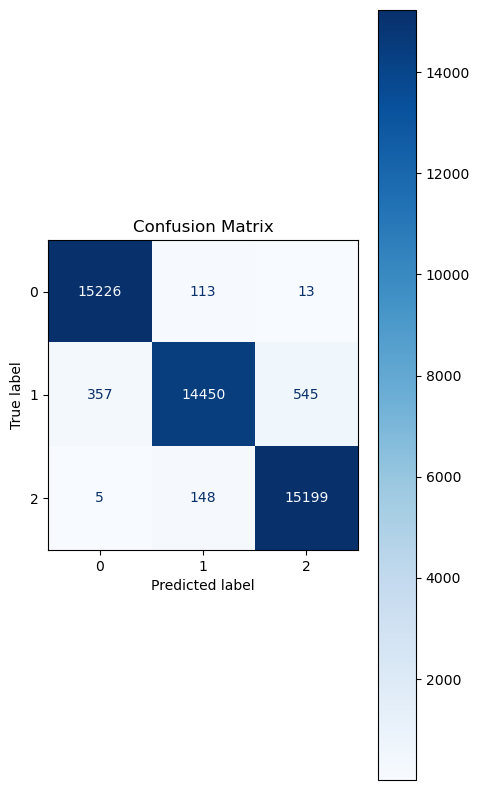

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     15352
           1       0.98      0.94      0.96     15352
           2       0.96      0.99      0.98     15352

    accuracy                           0.97     46056
   macro avg       0.97      0.97      0.97     46056
weighted avg       0.97      0.97      0.97     46056

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 283}
Best Score: 0.9647602918186555


In [191]:
# Perform grid search to get the best parameters for the random forest model 

from sklearn.model_selection import GridSearchCV

def random_forest_classifier(X_train, y_train):
    # Define the parameter grid for grid search
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 5],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'random_state' : [283]
    }

    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier(random_state=283)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(rf_classifier, param_grid, cv=2, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score from grid search
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Fit the classifier on the training data with the best parameters
    rf_classifier.set_params(**best_params)
    rf_classifier.fit(X_train, y_train)

    # Perform cross-fold validation with predictions
    y_pred = cross_val_predict(rf_classifier, X_train, y_train, cv=10)

    # Generate confusion matrix
    cm = confusion_matrix(y_train, y_pred)

    # Plot confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
    cm_display.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # Print accuracy, recall, precision, and F1 scores
    classification_rep = classification_report(y_train, y_pred, zero_division=0)
    print("Classification Report:\n", classification_rep)

    # Return the best parameters and best score
    return best_params, best_score

# Call the function with the resampled training data and labels
best_params, best_score = random_forest_classifier(X_train_resampled, y_train_resampled)

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)


#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV 

In [ ]:
# No change in performance in terms of performance evaluation metrics but the confusion matrix shows improved performnace 

##### Evaluation of Best Model on Test Data

(Discussed in section 4.2.2.Evaluation on Test data )

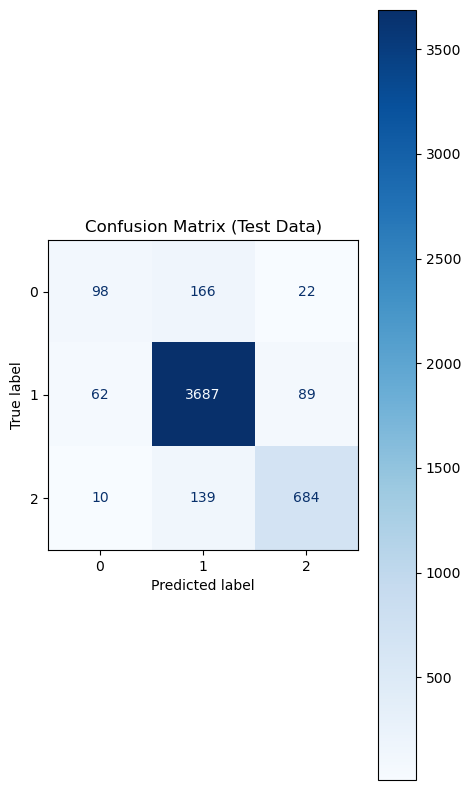

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.58      0.34      0.43       286
           1       0.92      0.96      0.94      3838
           2       0.86      0.82      0.84       833

    accuracy                           0.90      4957
   macro avg       0.79      0.71      0.74      4957
weighted avg       0.89      0.90      0.90      4957



In [195]:
def test_random_forest_classifier(X_train, y_train, X_test, y_test):
    # Define the best parameters
    best_params = {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}

    # Create a Random Forest classifier with the best parameters
    rf_classifier = RandomForestClassifier(random_state=283, **best_params)

    # Fit the classifier on the training data
    rf_classifier.fit(X_train, y_train)

    # Perform predictions on the test data
    y_pred = rf_classifier.predict(X_test)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
    cm_display.plot(cmap='Blues')
    plt.title("Confusion Matrix (Test Data)")
    plt.show()

    # Print classification report
    classification_rep = classification_report(y_test, y_pred, zero_division=0)
    print("Classification Report (Test Data):\n", classification_rep)

# Implement the function with the training and test data
test_random_forest_classifier(X_train_resampled, y_train_resampled, X_test_encoded, y_test)


In [ ]:
# there's better performance on test data for balanced model as compared to imbalanced data